# Jonathan Halverson
# Saturday, April 9, 2016
# Wine data with logistic regression (L1 norm) and random forest

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
columns = ['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', \
           'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', \
           'OD280/OD315 of diluted wines', 'Proline']
df = pd.read_csv('wine.csv', names=columns)

# shuffle the columns to test feature_importances_ below
from random import shuffle
cols = columns[1:]
shuffle(cols)
df = df[['class'] + cols]
df.head()

,class,Hue,Alcohol,Alcalinity of ash,Color intensity,Malic acid,Ash,Total phenols,Flavanoids,Proline,OD280/OD315 of diluted wines,Magnesium,Nonflavanoid phenols,Proanthocyanins
0,1,1.04,14.23,15.6,5.64,1.71,2.43,2.80,3.06,1065,3.92,127,0.28,2.29
1,1,1.05,13.20,11.2,4.38,1.78,2.14,2.65,2.76,1050,3.40,100,0.26,1.28
2,1,1.03,13.16,18.6,5.68,2.36,2.67,2.80,3.24,1185,3.17,101,0.30,2.81
3,1,0.86,14.37,16.8,7.80,1.95,2.50,3.85,3.49,1480,3.45,113,0.24,2.18
4,1,1.04,13.24,21.0,4.32,2.59,2.87,2.80,2.69,735,2.93,118,0.39,1.82


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
class                           178 non-null int64
Hue                             178 non-null float64
Alcohol                         178 non-null float64
Alcalinity of ash               178 non-null float64
Color intensity                 178 non-null float64
Malic acid                      178 non-null float64
Ash                             178 non-null float64
Total phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Proline                         178 non-null int64
OD280/OD315 of diluted wines    178 non-null float64
Magnesium                       178 non-null int64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


The description of the data says that there are no null values. This is found to be true.

In [4]:
df.describe().applymap(lambda x: round(x, 1))

,class,Hue,Alcohol,Alcalinity of ash,Color intensity,Malic acid,Ash,Total phenols,Flavanoids,Proline,OD280/OD315 of diluted wines,Magnesium,Nonflavanoid phenols,Proanthocyanins
count,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0,178.0
mean,1.9,1.0,13.0,19.5,5.1,2.3,2.4,2.3,2.0,746.9,2.6,99.7,0.4,1.6
std,0.8,0.2,0.8,3.3,2.3,1.1,0.3,0.6,1.0,314.9,0.7,14.3,0.1,0.6
min,1.0,0.5,11.0,10.6,1.3,0.7,1.4,1.0,0.3,278.0,1.3,70.0,0.1,0.4
25%,1.0,0.8,12.4,17.2,3.2,1.6,2.2,1.7,1.2,500.5,1.9,88.0,0.3,1.3
50%,2.0,1.0,13.1,19.5,4.7,1.9,2.4,2.4,2.1,673.5,2.8,98.0,0.3,1.6
75%,3.0,1.1,13.7,21.5,6.2,3.1,2.6,2.8,2.9,985.0,3.2,107.0,0.4,1.9
max,3.0,1.7,14.8,30.0,13.0,5.8,3.2,3.9,5.1,1680.0,4.0,162.0,0.7,3.6


### Correlation

In [5]:
df.corr().applymap(lambda x: round(x, 2))

,class,Hue,Alcohol,Alcalinity of ash,Color intensity,Malic acid,Ash,Total phenols,Flavanoids,Proline,OD280/OD315 of diluted wines,Magnesium,Nonflavanoid phenols,Proanthocyanins
class,1.00,-0.62,-0.33,0.52,0.27,0.44,-0.05,-0.72,-0.85,-0.63,-0.79,-0.21,0.49,-0.50
Hue,-0.62,1.00,-0.07,-0.27,-0.52,-0.56,-0.07,0.43,0.54,0.24,0.57,0.06,-0.26,0.30
Alcohol,-0.33,-0.07,1.00,-0.31,0.55,0.09,0.21,0.29,0.24,0.64,0.07,0.27,-0.16,0.14
Alcalinity of ash,0.52,-0.27,-0.31,1.00,0.02,0.29,0.44,-0.32,-0.35,-0.44,-0.28,-0.08,0.36,-0.20
Color intensity,0.27,-0.52,0.55,0.02,1.00,0.25,0.26,-0.06,-0.17,0.32,-0.43,0.20,0.14,-0.03
Malic acid,0.44,-0.56,0.09,0.29,0.25,1.00,0.16,-0.34,-0.41,-0.19,-0.37,-0.05,0.29,-0.22
Ash,-0.05,-0.07,0.21,0.44,0.26,0.16,1.00,0.13,0.12,0.22,0.00,0.29,0.19,0.01
Total phenols,-0.72,0.43,0.29,-0.32,-0.06,-0.34,0.13,1.00,0.86,0.50,0.70,0.21,-0.45,0.61
Flavanoids,-0.85,0.54,0.24,-0.35,-0.17,-0.41,0.12,0.86,1.00,0.49,0.79,0.20,-0.54,0.65
Proline,-0.63,0.24,0.64,-0.44,0.32,-0.19,0.22,0.50,0.49,1.00,0.31,0.39,-0.31,0.33


In [6]:
np.sort(np.unique(np.abs(df.iloc[:,1:].corr().values.ravel())))[-5:]

array([ 0.65269177,  0.69994936,  0.7871939 ,  0.8645635 ,  1.        ])

The data set is clean. We note that the largest value of the correlation is 0.86. Below we plot the features that are highly correlated. Using dimensionality reductions techniques it is often possible to ignore one of two correlated features.

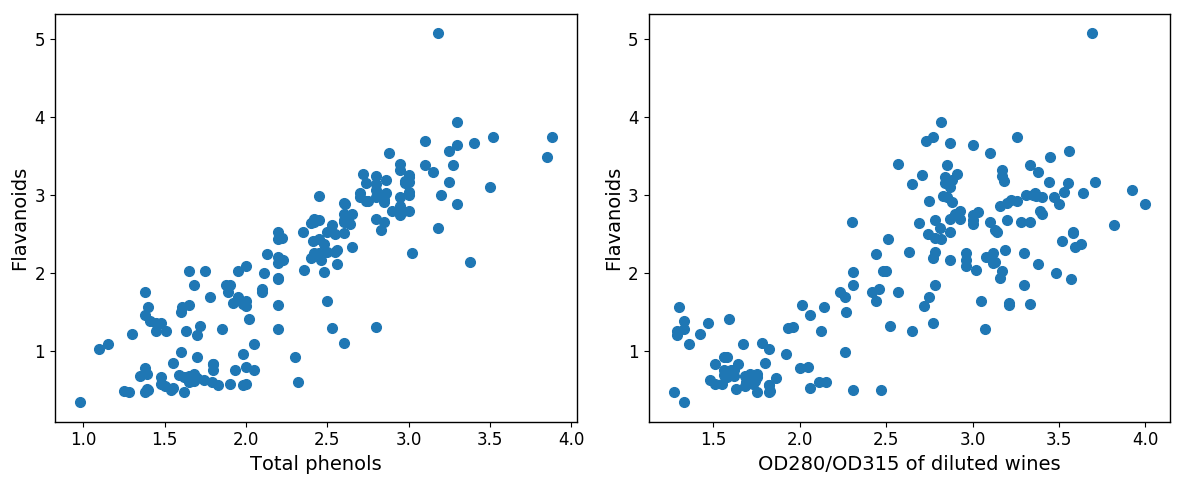

In [22]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax0.scatter(df['Total phenols'], df['Flavanoids'])
ax0.set_xlabel('Total phenols')
ax0.set_ylabel('Flavanoids')
ax1.scatter(df['OD280/OD315 of diluted wines'], df['Flavanoids'])
ax1.set_xlabel('OD280/OD315 of diluted wines')
ax1.set_ylabel('Flavanoids')
plt.tight_layout()

### Data preparation

In [8]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,1:].values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

We see that the values vary substantially so we will standardize all columns:

In [9]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Let's examine the standardized train and test data:

In [10]:
pd.DataFrame(X_train_std).describe().applymap(lambda x: round(x, 1))

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,133.0,133.0,133.0,133.0,133.0,133.0,133.0,133.0,133.0,133.0,133.0,133.0,133.0
mean,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.1,-2.1,-2.7,-1.7,-1.5,-3.7,-2.0,-1.6,-1.6,-1.9,-2.1,-1.8,-2.1
25%,-0.9,-0.8,-0.7,-0.8,-0.7,-0.5,-0.9,-1.0,-0.8,-1.1,-0.8,-0.7,-0.6
50%,0.1,0.0,-0.0,-0.2,-0.4,-0.0,0.1,0.1,-0.2,0.3,-0.2,-0.2,-0.1
75%,0.7,0.8,0.6,0.5,0.7,0.7,0.8,0.8,0.8,0.8,0.4,0.6,0.6
max,2.2,2.4,3.2,3.1,3.1,3.1,2.1,1.8,2.6,2.0,4.2,2.3,3.4


In [11]:
pd.DataFrame(X_test_std).describe().applymap(lambda x: round(x, 1))

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
mean,-0.0,-0.1,-0.0,0.1,-0.1,0.0,0.2,0.1,-0.1,0.1,-0.2,-0.0,-0.2
std,1.0,1.2,1.0,1.2,1.1,1.0,1.2,1.2,1.1,1.0,0.9,0.9,0.9
min,-1.8,-2.6,-1.9,-1.4,-1.3,-2.4,-2.2,-1.8,-1.4,-1.8,-1.6,-1.5,-2.1
25%,-0.6,-1.0,-0.8,-0.9,-0.8,-0.6,-0.8,-0.8,-0.9,-0.8,-1.0,-0.8,-0.8
50%,-0.1,-0.2,-0.2,-0.0,-0.5,0.1,0.3,0.2,-0.4,0.4,-0.3,-0.3,-0.3
75%,0.6,1.0,0.6,0.9,0.4,0.6,1.0,1.0,0.9,0.9,0.6,0.5,0.4
max,3.3,1.8,2.7,3.6,2.9,3.2,2.7,3.2,3.1,1.6,1.9,2.1,1.9


### Machine learning models

In this section we try a few different classifiers beginning with logistic regression. The C parameter corresponds to the inverse regularization parameter $\lambda$. Here with vary this parameter for the L1 and L2 penalties. Note that by default the one-versus-rest method is used instead of multinomial.

###### Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-3, 5, base=10)
param_grid = dict(C=C_range, penalty=['l1', 'l2'])

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)
print grid.best_score_
print grid.best_params_

0.97191011236
{'penalty': 'l1', 'C': 167.68329368110065}


Using K-fold cross validation, the optimal parameter and regularization approach were found. Regularization helps prevents overfitting by penalizing large weights. The L1 penalty drives unimportant feature weights to zero. We illustrate this below using $\lambda =10$:

In [13]:
lr = LogisticRegression(C=0.1, penalty='l1')
lr.fit(X_train_std, y_train)
print lr.intercept_
print lr.coef_
print 'Accuracy (train): %.3f' % lr.score(X_train_std, y_train)
print 'Accuracy (test): %.3f' % lr.score(X_test_std, y_test)

[-0.28030327 -0.20973089 -0.84369093]
[[ 0.          0.39161923 -0.04441459  0.          0.          0.          0.
   0.77320541  1.23924257  0.          0.          0.          0.        ]
 [ 0.07561025 -0.65637837  0.         -0.96320056  0.         -0.03585161
   0.          0.         -0.53859179  0.          0.          0.          0.        ]
 [-0.45405154  0.          0.          0.64109814  0.02137971  0.          0.
  -0.82083445  0.         -0.23830953  0.          0.          0.        ]]
Accuracy (train): 0.992
Accuracy (test): 0.978


We see that the L1 norm penalty has driven many of the coefficients to zero. Because one-versus-rest was used, three sets of coefficients are produced.

###### Random forest

Random forest works by making a large number of decision trees that operate of different subsets of the data with predictions made based on majority vote. The first step is to choose a subset of the data by randomly selecting n cases with replacement. This is called bootstrapping. scikit-learn uses $n$ equal to the training set. In general, the larger $n$ the more likely to overfit. A decision tree is then created using a criteria for the information gain (like gini, entropy or classification error). At each node only a random subset of features are considered. This number is taken as the square root of the total number of features. The final prediction for each cases is determined by majority vote of the aggregrated results.

Note we do need to use the standardized data for RF:

In [14]:
from sklearn.ensemble import RandomForestClassifier
n_est = range(1, 11) + range(20, 110, 10) + range(150, 550, 50)
scores = []
for n in n_est:
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', n_jobs=-1)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))

(0.75, 1.05)

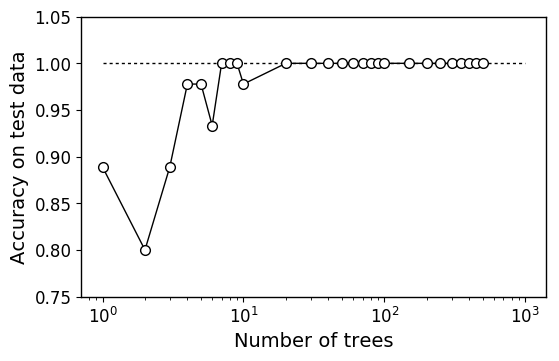

In [15]:
plt.semilogx([1, 1000], [1, 1], 'k:')
plt.semilogx(n_est, scores, 'k-', marker='o', mfc='w')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy on test data')
plt.ylim(0.75, 1.05)

Random forest is an ensemble technique so we typically do not need to find hyperparameters. Nor do we need to prune the trees -- unlike conventional decision trees. In general, its performance increases with increasing number of trees until saturation is reached. We see in the plot above that when the number of trees exceeds around 30 the accuracy is perfect (for some random_state values).

Below we plot the imporatance of each feature according to the RF model. The feature importance is the averaged impurity decrease computed from all decision trees in the forest.

In [23]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [24]:
importances

array([ 0.09844223,  0.11104032,  0.0234901 ,  0.14970125,  0.03039509,
        0.0103717 ,  0.06975729,  0.18398846,  0.1449221 ,  0.11863275,
        0.02676479,  0.01160759,  0.02088633])

In [26]:
indices

array([ 7,  3,  8,  9,  1,  0,  6,  4, 10,  2, 12, 11,  5])

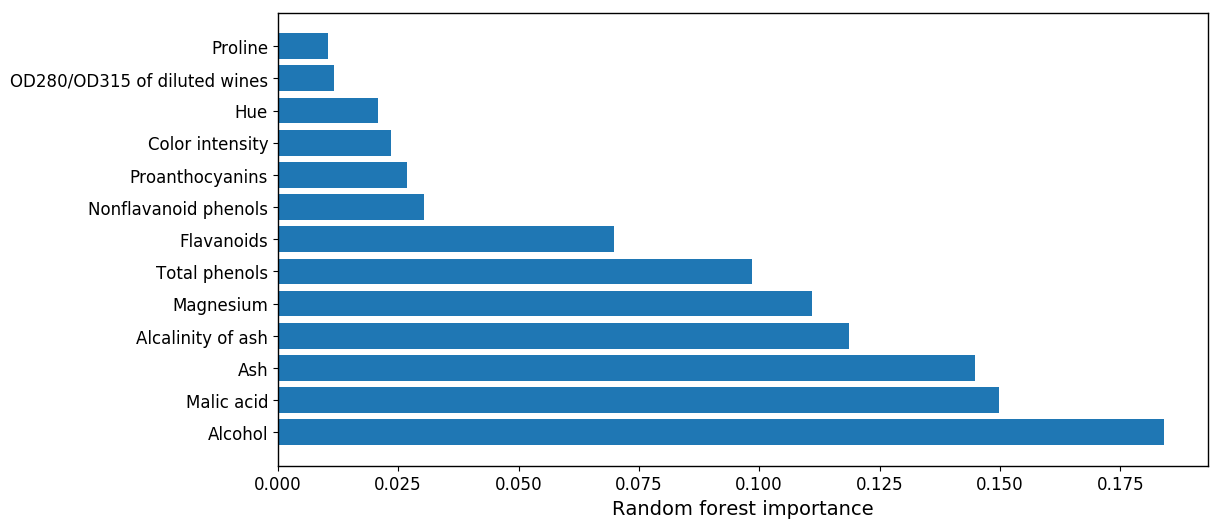

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.barh(range(X_train.shape[1]), importances[indices],  align='center')
plt.yticks(range(X_train.shape[1]), columns[1:], rotation=0)
plt.xlabel('Random forest importance')

One of the downsides of RF is the difficulty of intrepretation. A feature that is correlated with another feature may have a low importance while it may be highly predictive in another model. Conventional decision trees are easy to intrepret and often preferred in medical fields.

###### K-Nearest Neighbors

The entire training data set is needed to apply KNN to new data. One must be careful of the curse of dimensionality where having a large number of features leads to overfitting because high-dimensional spaces are vast and points in space tend to be far apart. In fact, the ratio of the minimum distance to average distance of random points in a unit hypercube approaches 1.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = dict(n_neighbors=range(1, 26))
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_std, y_train)
print grid.best_score_
print grid.best_params_

0.962406015038
{'n_neighbors': 13}


In [19]:
knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn.fit(X_train_std, y_train)
print 'Accuracy (train): %.3f' % knn.score(X_train_std, y_train)
print 'Accuracy (test): %.3f' % knn.score(X_test_std, y_test)

Accuracy (train): 0.970
Accuracy (test): 0.978
